In [10]:
import arcgis
import geopandas as gpd

In [2]:
service_url = "https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Traffic_Counts_view/FeatureServer/0"

In [3]:
traffic_layer = arcgis.features.FeatureLayer(service_url)

In [4]:
all_counts = traffic_layer.query()

In [13]:
sdf = all_counts.sdf

In [17]:
all_counts_gdf = gpd.GeoDataFrame(sdf, geometry=sdf.SHAPE)

<Axes: >

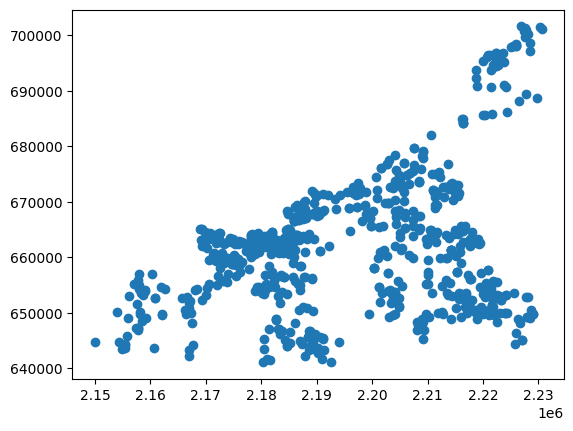

In [18]:
all_counts_gdf.plot()